# Deep learning volatility

In [1]:
%config Completer.use_jedi=False

import os
os.chdir("Data")
# import gzip
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import csv
import pandas as pd
import scipy

In [26]:
# df = np.loadtxt("parameters_impliedVols.txt")
df = np.loadtxt('impliedVols_server70_market.txt')
# np.savetxt("parameters_impliedVols.txt", df, fmt="%.4f")
xx=df[:,:6]
yy=df[:,6:]
print(xx.shape, yy.shape)
# maturities = np.array([0.1, 0.2, 0.3, 0.5, 0.75, 1.0, 1.5, 2.0])
# strikes = np.array([95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105])
maturities = np.array([0.06, 0.15, 0.31, 0.56])
strikes = np.array([5.25, 5.50, 5.75, 6.00, 6.25])
strike_dim = len(strikes)
maturities_dim = len(maturities)

xx[0], yy[0][:11]


(4000, 6) (4000, 20)


(array([6.5300e-01, 1.5923e+00, 3.2800e-01, 9.7500e-02, 1.1000e-03,
        9.9500e-02]),
 array([0.0347, 0.0548, 0.0001, 0.0001, 0.0001, 0.037 , 0.0458, 0.0643,
        0.0001, 0.0001, 0.0395]))

In [13]:
#remove invalid paramters
invalid = np.where(yy == yy.min())[0]
xx = np.delete(xx, (invalid), axis=0)
yy = np.delete(yy, (invalid), axis=0)
xx.shape, yy.shape

((2790, 6), (2790, 20))

$$
\begin{aligned}
dS_t &= S_t\sqrt{V_t}dW_t,\\
dV_t &= \kappa(\theta-V_t)dt + \nu\sqrt{V_t}dB_t
\end{aligned}
$$

# Step 1: Data Generation


### **Inputs:** 
####  1. $\nu_{0}$ spot variance 
####  2. $\rho$ spot-vol correlation,
####  3. $\sigma$ vol of vol
####  4. $\theta$ long term vol
####  5. $\kappa$ speed of mean reversion 
    
    
### **Outputs:**
#### Implied volatility surface (11x8=88 points)

## Scaling:

### Model Parameters $\theta\to scale(\theta)\in[0,1]$
$$scale(\theta^i)=\frac{(\theta^i-\theta^i_{min})}{\theta^i_{max}-\theta^i_{min}},\quad i \in |\Theta|$$

### Implied volatilities
$$scale(\sigma_{BS}^{i,j})=\frac{\sigma_{BS}^{i,j}-\mathbb{E}[\sigma_{BS}^{i,j}]}{std(\sigma_{BS}^{i,j})},\quad i\in\text{Maturities},\; j\in \text{Strikes}$$

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    xx, yy, test_size=0.15, random_state=42)
from sklearn.preprocessing import StandardScaler

scale = StandardScaler()
y_train_transform = scale.fit_transform(y_train)
y_test_transform = scale.transform(y_test)


$\alpha\in[0.005, 0.2],\; \lambda\in[0.1, 2.0],\; a\in[0.1, 1.0],\; b\in[0.01, 1.0],\; c\in[0.0001, 0.01],\; Z0\in[0.01, 0.3]$

In [15]:
np.max(xx, axis=0), np.min(xx, axis = 0)

(array([0.7   , 1.9998, 0.9999, 0.9995, 0.01  , 0.2999]),
 array([5.050e-01, 1.008e-01, 1.011e-01, 1.060e-02, 1.000e-04, 1.010e-02]))

In [16]:
ub=[0.7,   2.0,  1.0,  1.0,  0.01,   0.3]
lb=[0.505, 0.1,  0.1,  0.01, 0.0001, 0.01]

def myscale(x):
    res=np.zeros(6)
    for i in range(6):
        res[i]=(x[i] - lb[i])/ (ub[i] - lb[i])
    return res

def myinverse(x):
    res=np.zeros(6)
    for i in range(6):
        res[i] = lb[i] + (ub[i] - lb[i])*x[i]
    return res

# def myscale(x):
#     res=np.zeros(6)
#     for i in range(6):
#         res[i]=(x[i] - (ub[i] + lb[i])*0.5) * 2 / (ub[i] - lb[i])
        
#     return res
# def myinverse(x):
#     res=np.zeros(6)
#     for i in range(6):
#         res[i]=x[i]*(ub[i] - lb[i]) *0.5 + (ub[i] + lb[i])*0.5
        
#     return res

In [17]:
x_train_transform = np.array([myscale(x) for x in X_train])
x_test_transform = np.array([myscale(x) for x in X_test])
x_test_transform.shape

(419, 6)

# Step 2. Create the Neural Network

In [18]:
import keras
from keras.layers import Activation
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects
keras.backend.set_floatx('float64')


input1 = keras.layers.Input(shape=(6,))
x1 = keras.layers.Dense(30,activation = 'elu')(input1)
x2=keras.layers.Dense(30,activation = 'elu')(x1) 
x3=keras.layers.Dense(30,activation = 'elu')(x2) 


x4=keras.layers.Dense(20,activation = 'linear')(x3)


modelGEN = keras.models.Model(inputs=input1, outputs=x4)
modelGEN.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 6)]               0         
_________________________________________________________________
dense_4 (Dense)              (None, 30)                210       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                930       
_________________________________________________________________
dense_6 (Dense)              (None, 30)                930       
_________________________________________________________________
dense_7 (Dense)              (None, 20)                620       
Total params: 2,690
Trainable params: 2,690
Non-trainable params: 0
_________________________________________________________________


# Step 3. Fit the Neural Network (No need to run the code, parameters are stored on a .h5 file)

In [19]:
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))
modelGEN.compile(loss = root_mean_squared_error, optimizer = "adam")



In [20]:
modelGEN.fit(x_train_transform, y_train_transform, 
             batch_size=32,
#              validation_split = 0.2,
             validation_data = (x_test_transform, y_test_transform),
             epochs = 100, verbose = True,shuffle=1)#,callbacks=[earlystop])

Epoch 1/100
75/75 [==============================] - 0s 6ms/step - loss: 0.8649 - val_loss: 0.6241
Epoch 2/100
75/75 [==============================] - 0s 2ms/step - loss: 0.5491 - val_loss: 0.4589
Epoch 3/100
75/75 [==============================] - 0s 1ms/step - loss: 0.4224 - val_loss: 0.3617
Epoch 4/100
75/75 [==============================] - 0s 2ms/step - loss: 0.3558 - val_loss: 0.3048
Epoch 5/100
75/75 [==============================] - 0s 1ms/step - loss: 0.3010 - val_loss: 0.2694
Epoch 6/100
75/75 [==============================] - 0s 1ms/step - loss: 0.2804 - val_loss: 0.2652
Epoch 7/100
75/75 [==============================] - 0s 1ms/step - loss: 0.2683 - val_loss: 0.2472
Epoch 8/100
75/75 [==============================] - 0s 1ms/step - loss: 0.2579 - val_loss: 0.2422
Epoch 9/100
75/75 [==============================] - 0s 1ms/step - loss: 0.2517 - val_loss: 0.2297
Epoch 10/100
75/75 [==============================] - 0s 1ms/step - loss: 0.2421 - val_loss: 0.2231
Epoch 11/

75/75 [==============================] - 0s 1ms/step - loss: 0.0700 - val_loss: 0.0579
Epoch 84/100
75/75 [==============================] - 0s 1ms/step - loss: 0.0700 - val_loss: 0.0604
Epoch 85/100
75/75 [==============================] - 0s 1ms/step - loss: 0.0731 - val_loss: 0.0619
Epoch 86/100
75/75 [==============================] - 0s 1ms/step - loss: 0.0704 - val_loss: 0.0677
Epoch 87/100
75/75 [==============================] - 0s 1ms/step - loss: 0.0737 - val_loss: 0.0698
Epoch 88/100
75/75 [==============================] - 0s 1ms/step - loss: 0.0699 - val_loss: 0.0700
Epoch 89/100
75/75 [==============================] - 0s 1ms/step - loss: 0.0687 - val_loss: 0.0572
Epoch 90/100
75/75 [==============================] - 0s 1ms/step - loss: 0.0708 - val_loss: 0.0627
Epoch 91/100
75/75 [==============================] - 0s 1ms/step - loss: 0.0686 - val_loss: 0.0576
Epoch 92/100
75/75 [==============================] - 0s 1ms/step - loss: 0.0675 - val_loss: 0.0881
Epoch 93/100


### Store/Load optimal NN parameteres

In [21]:
modelGEN.save_weights('HestonNNWeights.h5')

In [22]:
modelGEN.load_weights('HestonNNWeights.h5')

In [23]:
NNParameters=[]
for i in range(1,len(modelGEN.layers)):
    NNParameters.append(modelGEN.layers[i].get_weights())

# Step 4. Optimisation
### (Numpy Implementation of the Neural Network tends to be faster than Keras)

Here the *elu* function writes:
$$elu(x) = \begin{cases}e^{x}-1,\; x<0\\
x,\; x\geq 0.
\end{cases}$$

In [24]:
NumLayers=3
def elu(x):
    #Careful function ovewrites x
    ind=(x<0)
    x[ind]=np.exp(x[ind])-1
    return x
def eluPrime(y):
    # we make a deep copy of input x
    x=np.copy(y)
    ind=(x<0)
    x[ind]=np.exp(x[ind])
    x[~ind]=1
    return x
def NeuralNetwork(x):
    input1=x
    for i in range(NumLayers):
        input1=np.dot(input1,NNParameters[i][0])+NNParameters[i][1]
        #Elu activation
        input1=elu(input1)
    #The output layer is linnear
    i+=1
    return np.dot(input1,NNParameters[i][0])+NNParameters[i][1]
def NeuralNetworkGradient(x):
    input1=x
    #Identity Matrix represents Jacobian with respect to initial parameters
    grad=np.eye(6)
    #Propagate the gradient via chain rule
    for i in range(NumLayers):
        input1=(np.dot(input1,NNParameters[i][0])+NNParameters[i][1])
        grad=(np.einsum('ij,jk->ik', grad, NNParameters[i][0]))
        #Elu activation
        grad*=eluPrime(input1)
        input1=elu(input1)
    #input1.append(np.dot(input1[i],NNParameters[i+1][0])+NNParameters[i+1][1])
#     grad=np.einsum('ij,jk->ik',grad,NNParameters[i+1][0])
    grad=np.dot(grad,NNParameters[i+1][0])
    #grad stores all intermediate Jacobians, however only the last one is used here as output
    return grad

# Compute Implied vol relative errors on Test set

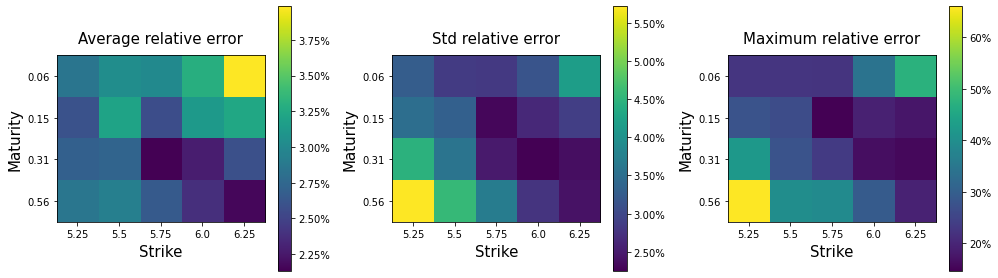

In [27]:
strikes_dim=len(strikes)
maturities_dim=len(maturities)
##### AVERAGE VALUES #######
X_sample = x_test_transform
y_sample = y_test

prediction=[scale.inverse_transform(modelGEN.predict(X_sample[i].reshape(1,6))[0]) for i in range(len(X_sample))]

plt.figure(1,figsize=(14,4))
ax=plt.subplot(1,3,1)
err = np.mean(100*np.abs((y_sample-prediction)/y_sample),axis = 0)
plt.title("Average relative error",fontsize=15,y=1.04)
plt.imshow(err.reshape(maturities_dim,strikes_dim))
plt.colorbar(format=mtick.PercentFormatter())

ax.set_xticks(np.linspace(0,len(strikes)-1,len(strikes)))
ax.set_xticklabels(strikes)
ax.set_yticks(np.linspace(0,len(maturities)-1,len(maturities)))
ax.set_yticklabels(maturities)
plt.xlabel("Strike",fontsize=15,labelpad=5)
plt.ylabel("Maturity",fontsize=15,labelpad=5)

ax=plt.subplot(1,3,2)
err = 100*np.std(np.abs((y_sample-prediction)/y_sample),axis = 0)
plt.title("Std relative error",fontsize=15,y=1.04)
plt.imshow(err.reshape(maturities_dim,strikes_dim))
plt.colorbar(format=mtick.PercentFormatter())
ax.set_xticks(np.linspace(0,len(strikes)-1,len(strikes)))
ax.set_xticklabels(strikes)
ax.set_yticks(np.linspace(0,len(maturities)-1,len(maturities)))
ax.set_yticklabels(maturities)
plt.xlabel("Strike",fontsize=15,labelpad=5)
plt.ylabel("Maturity",fontsize=15,labelpad=5)

ax=plt.subplot(1,3,3)
err = 100*np.max(np.abs((y_sample-prediction)/y_sample),axis = 0)
plt.title("Maximum relative error",fontsize=15,y=1.04)
plt.imshow(err.reshape(maturities_dim,strikes_dim))
plt.colorbar(format=mtick.PercentFormatter())
ax.set_xticks(np.linspace(0,len(strikes)-1,len(strikes)))
ax.set_xticklabels(strikes)
ax.set_yticks(np.linspace(0,len(maturities)-1,len(maturities)))
ax.set_yticklabels(maturities)
plt.xlabel("Strike",fontsize=15,labelpad=5)
plt.ylabel("Maturity",fontsize=15,labelpad=5)
plt.tight_layout()
# plt.savefig('HestonNNErrors.png', dpi=300)
plt.show()


# Plot sample Smiles

[0.628  0.7825 0.2099 0.8622 0.0061 0.1775]


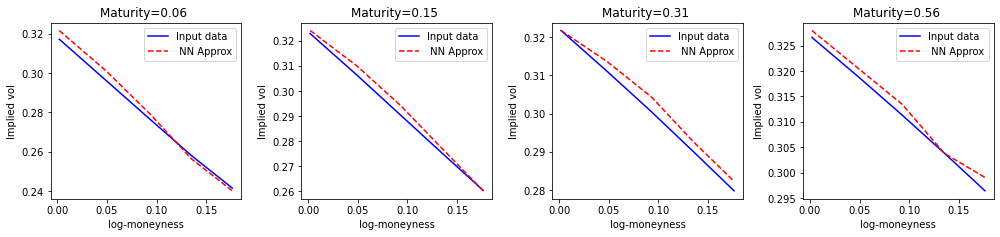

[0.5223 0.6421 0.4884 0.6125 0.0053 0.088 ]


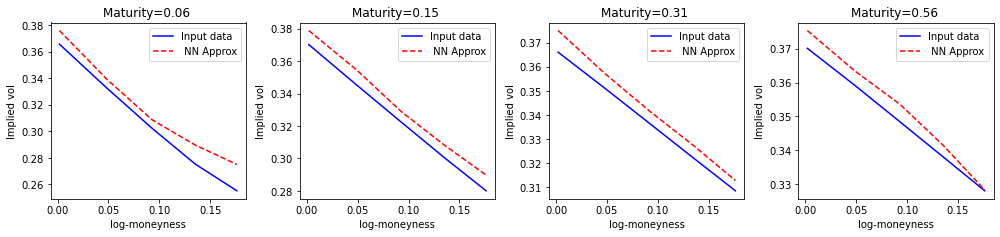

[0.6501 0.8223 0.8671 0.8919 0.0033 0.1108]


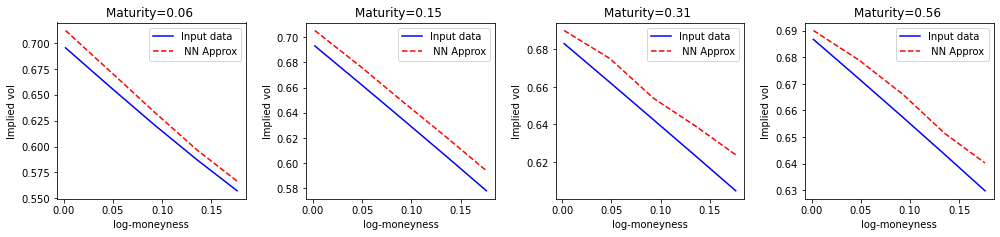

[0.5367 1.7739 0.8455 0.3231 0.0025 0.0553]


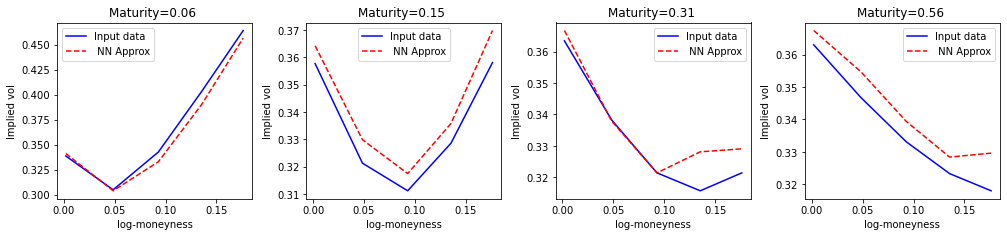

[0.6655 0.7953 0.6296 0.8303 0.0082 0.1377]


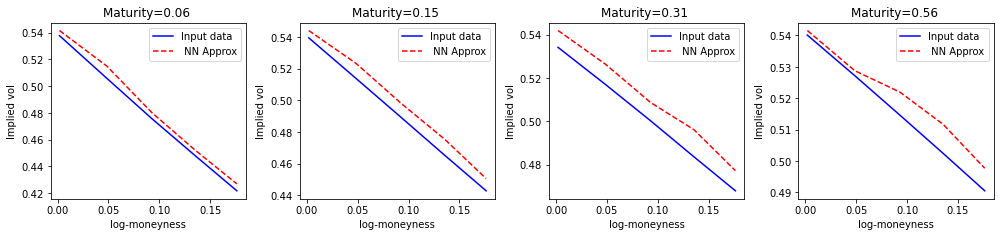

[0.5824 1.4454 0.3333 0.0677 0.0078 0.2559]


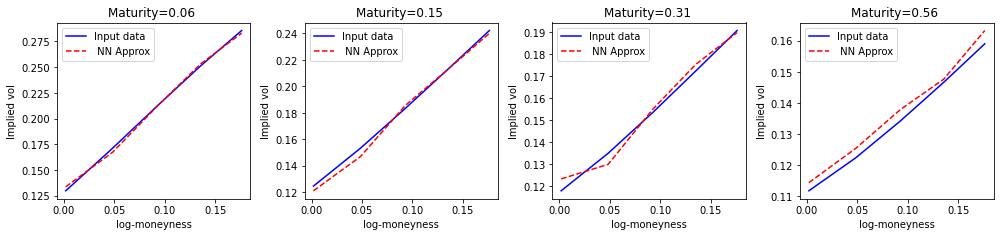

[5.9850e-01 1.4054e+00 3.6770e-01 5.7200e-01 3.0000e-04 8.2600e-02]


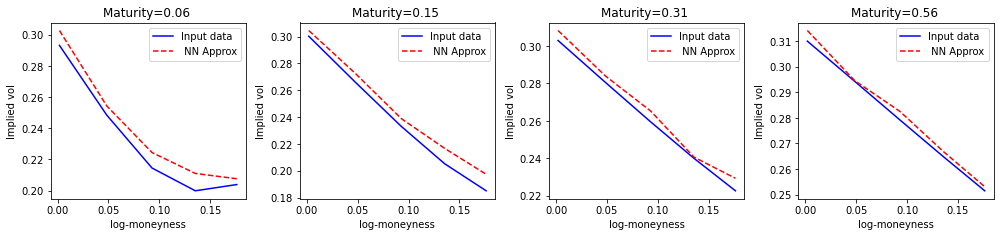

[0.5736 0.706  0.1617 0.7946 0.0078 0.1112]


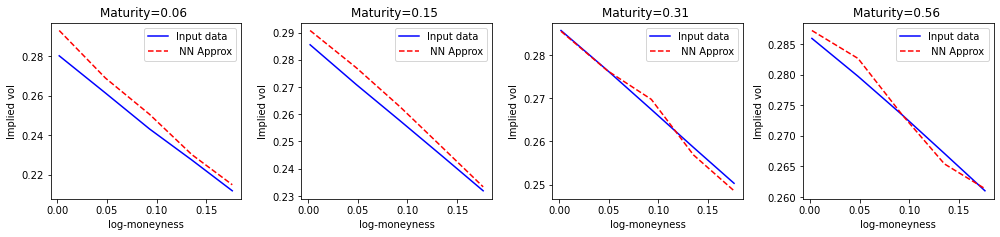

[0.6946 1.3978 0.7015 0.9247 0.0076 0.0419]


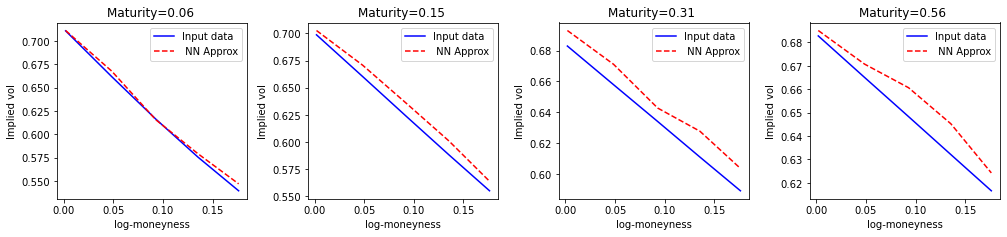

[0.6434 1.96   0.5338 0.54   0.009  0.0576]


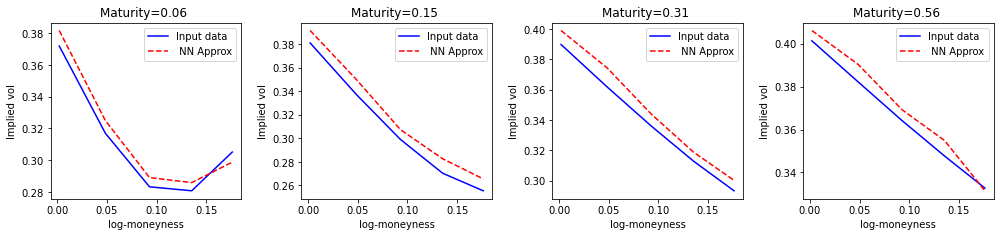

[0.6531 1.2045 0.9265 0.554  0.0022 0.0751]


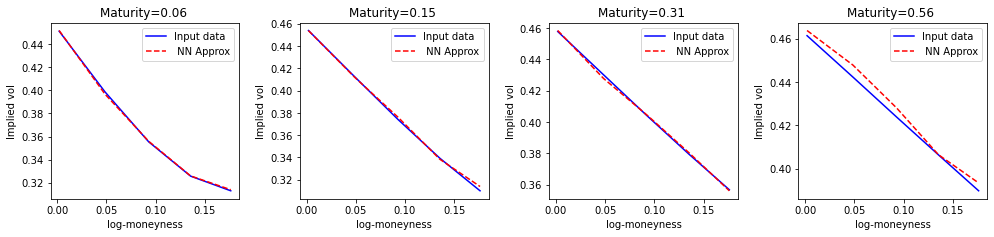

[0.6875 0.4962 0.7136 0.5862 0.001  0.2894]


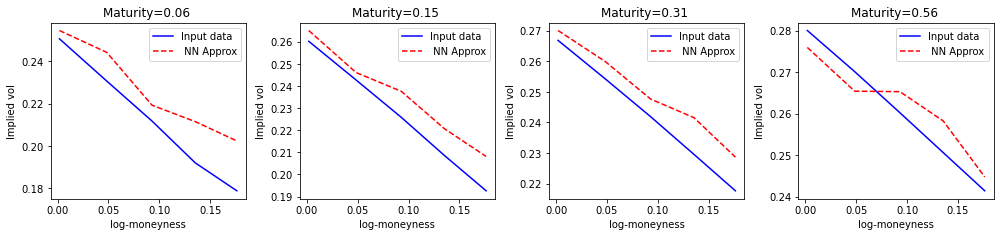

[0.5416 1.2649 0.795  0.7031 0.0036 0.264 ]


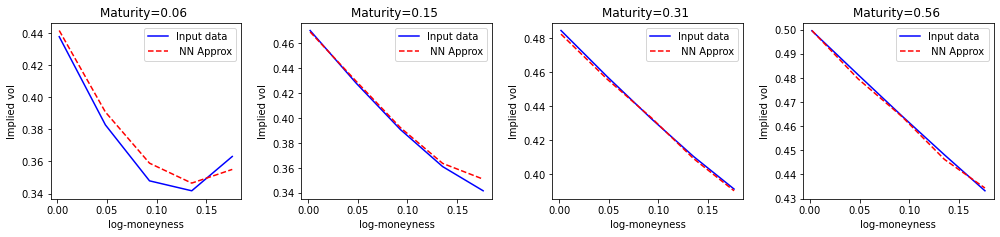

[0.618  1.3905 0.2564 0.8225 0.0066 0.1607]


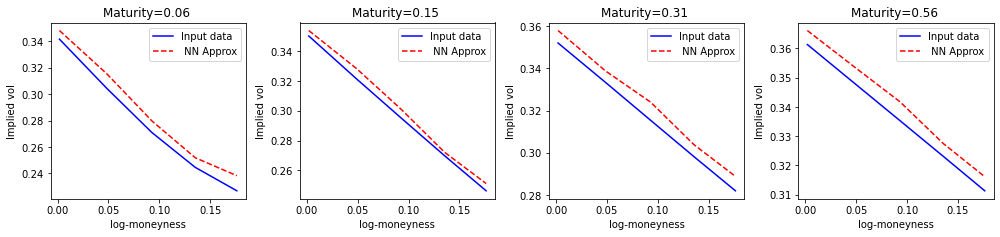

[0.6267 0.8429 0.746  0.9477 0.0095 0.1448]


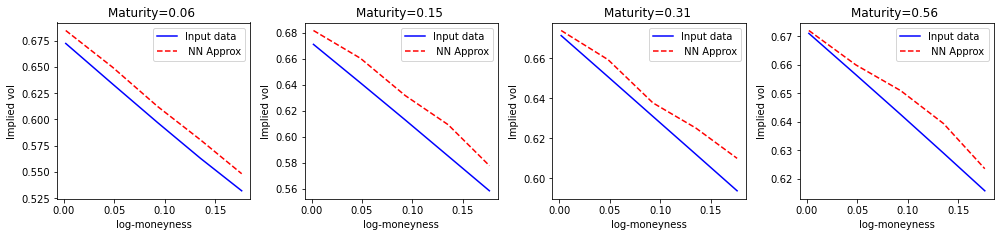

[0.6136 1.5848 0.3944 0.6341 0.0018 0.2768]


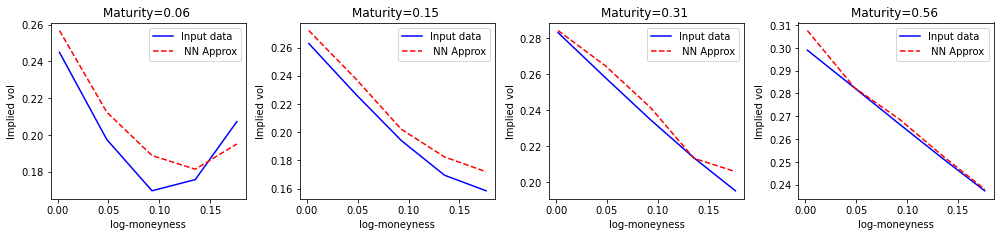

[6.6430e-01 1.8578e+00 9.2340e-01 7.1430e-01 7.0000e-04 2.7060e-01]


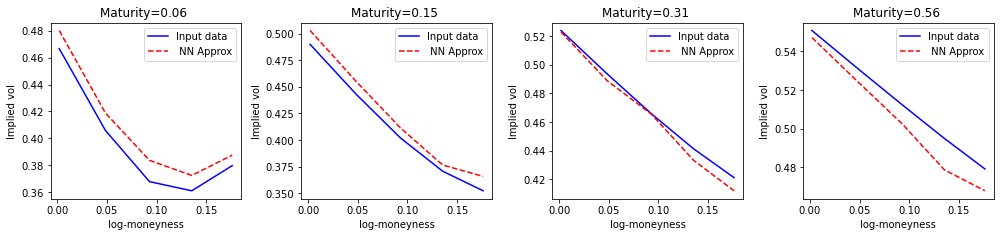

[0.5462 0.7836 0.6987 0.5471 0.0029 0.1   ]


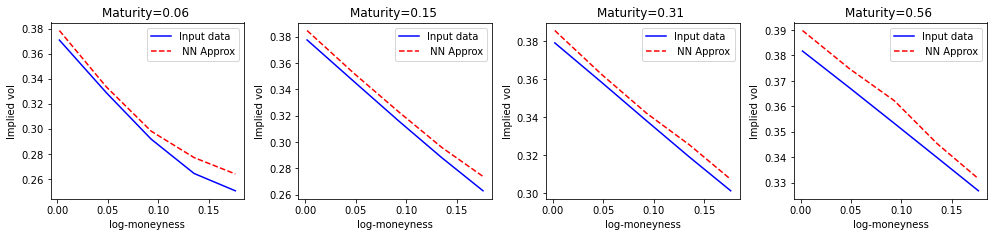

[0.6106 1.3951 0.9549 0.0425 0.0039 0.069 ]


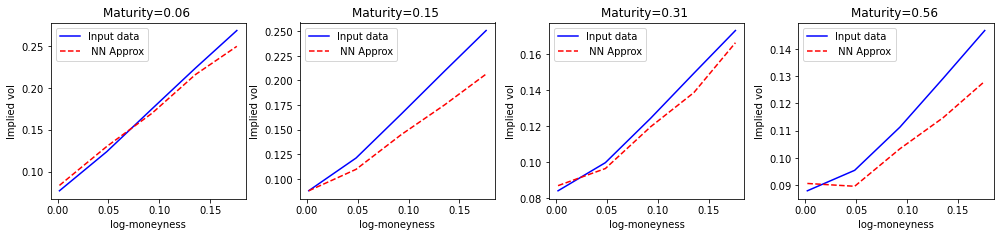

[0.5553 1.3458 0.5133 0.6512 0.0059 0.1165]


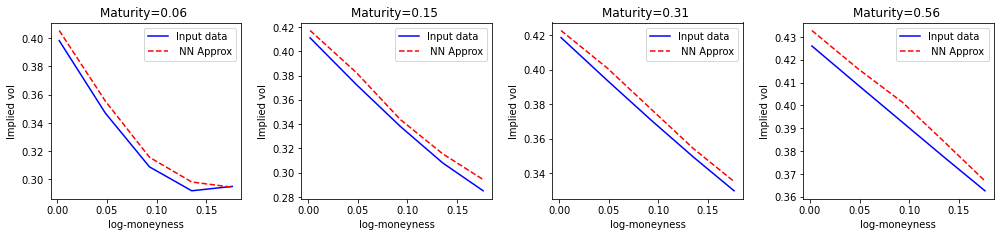

In [30]:
# S0=100.
S0 = 5.24
import time
for i in range(20):
    sample_ind = 5*i
    X_sample = x_test_transform[sample_ind]
    y_sample = y_test[sample_ind]
    print(myinverse(X_sample))

    prediction=scale.inverse_transform(modelGEN.predict(X_sample.reshape(1,6))[0])
    plt.figure(1,figsize=(14,6))
    for i in range(maturities_dim):
        plt.subplot(2,4,i+1)

        plt.plot(np.log(strikes/S0),y_sample[i*strikes_dim:(i+1)*strikes_dim],'b',label="Input data")
        plt.plot(np.log(strikes/S0),prediction[i*strikes_dim:(i+1)*strikes_dim],'--r',label=" NN Approx")


        plt.title("Maturity=%1.2f "%maturities[i])
        plt.xlabel("log-moneyness")
        plt.ylabel("Implied vol")

        plt.legend()
    plt.tight_layout()
    plt.show()
#     time.sleep(5)
    

# Use gradient methods for optimisation

In [31]:
def CostFunc(x,sample_ind):
    return np.sum(np.power((NeuralNetwork(x)-y_test_transform[sample_ind]),2))
def Jacobian(x,sample_ind):
    return 2*np.sum((NeuralNetwork(x)-y_test_transform[sample_ind])*NeuralNetworkGradient(x),axis=1)
#Cost Function for Levenberg Marquardt
def CostFuncLS(x,sample_ind):
    return (NeuralNetwork(x)-y_test_transform[sample_ind])
def JacobianLS(x,sample_ind):
    return NeuralNetworkGradient(x).T

In [41]:
len(X_test), X_test.shape
X_test[:10]

array([[0.628 , 0.7825, 0.2099, 0.8622, 0.0061, 0.1775],
       [0.6722, 0.8186, 0.9888, 0.6923, 0.0099, 0.2601],
       [0.5136, 1.011 , 0.669 , 0.0214, 0.0025, 0.2166],
       [0.523 , 0.1365, 0.2385, 0.9117, 0.0055, 0.0595],
       [0.5141, 1.8609, 0.23  , 0.7731, 0.0023, 0.297 ],
       [0.5223, 0.6421, 0.4884, 0.6125, 0.0053, 0.088 ],
       [0.5708, 1.4686, 0.7799, 0.1715, 0.0031, 0.1415],
       [0.5449, 0.534 , 0.1734, 0.7312, 0.0099, 0.1802],
       [0.6735, 1.1733, 0.2103, 0.8269, 0.0038, 0.0147],
       [0.5385, 1.7252, 0.812 , 0.4724, 0.0073, 0.188 ]])

In [33]:
import time

Approx=[]
Timing = []

solutions=np.zeros(6)
init=lb

for i in range(len(X_test)):
    disp=str(i+1)+"/" + str(len(X_test))
    print (disp, end="\r")
    #Levenberg-Marquardt
    start= time.time()
    I=scipy.optimize.least_squares(CostFuncLS, init, JacobianLS,method='lm',args=(i,),gtol=1E-10)
    end= time.time()
    solutions=myinverse(I.x)
    times=end-start
    
    Approx.append(np.copy(solutions))
    Timing.append(np.copy(times))
    
print("time spent: %ss"%np.round(np.sum(Timing), 6))
# print("solution: ", np.round(np.mean(Approx, axis=0), 6))

time spent: 5.41944s


# Save the Lavenberg-Marquardt Optimal parameters

In [39]:
LMParameters=np.array([Approx[i] for i in range(len(Approx))])
np.savetxt("NNParametersQuadraticRoughHeston.txt",LMParameters)
LMParameters = np.loadtxt("NNParametersQuadraticRoughHeston.txt")
LMParameters.shape
np.mean(LMParameters, axis=0)

array([ 0.42435214, -1.74075504, -0.23756785, -0.58957642,  0.01315615,
       -0.09846712])

# Calibration Errors with Levenberg-Marquardt

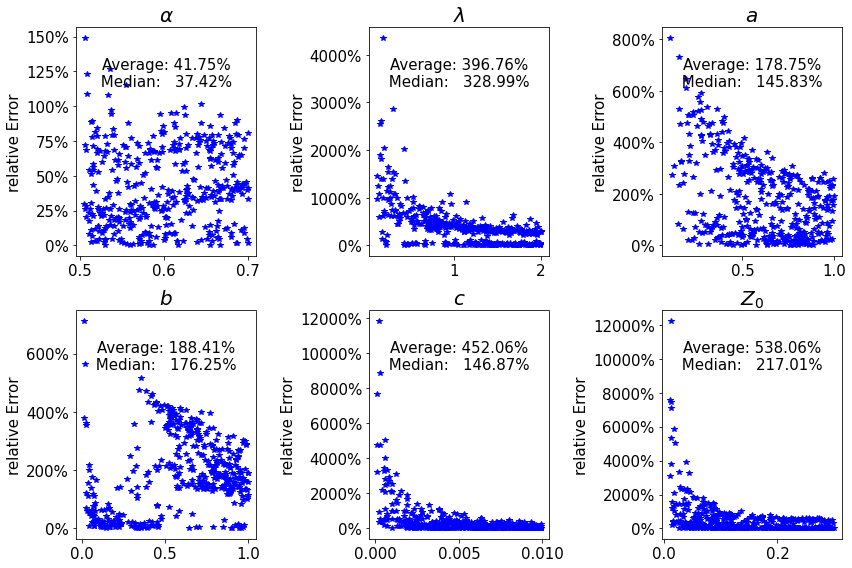

In [35]:
titles=["$\\alpha$","$\\lambda$","$a$","$b$", "$c$","$Z_0$"]
average=np.zeros([6,len(X_test)])
fig=plt.figure(figsize=(12,8))
for u in range(6):
    ax=plt.subplot(2,3,u+1)
    x=X_test[:len(X_test),u]
#     print(abs(LMParameters[:1800,u]))
#     print(100*np.abs(LMParameters[:1800,u]))
    plt.plot(x,100*np.abs(LMParameters[:len(X_test),u]-x)/np.abs(x),'b*')
    average[u,:]=np.abs(LMParameters[:len(X_test),u]-x)/np.abs(x)
    
    plt.title(titles[u],fontsize=20)
    plt.ylabel('relative Error',fontsize=15)
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter() )
    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.tick_params(axis='both', which='minor', labelsize=15)
    plt.text(0.5, 0.8, 'Average: %1.2f%%\n Median:   %1.2f%% '%(np.mean(100*average[u,:]),np.quantile(100*average[u,:],0.5)), horizontalalignment='center',verticalalignment='center', transform=ax.transAxes,fontsize=15)
plt.tight_layout()

# plt.savefig('HestonParameterRelativeErrors.png', dpi=300)
plt.show()

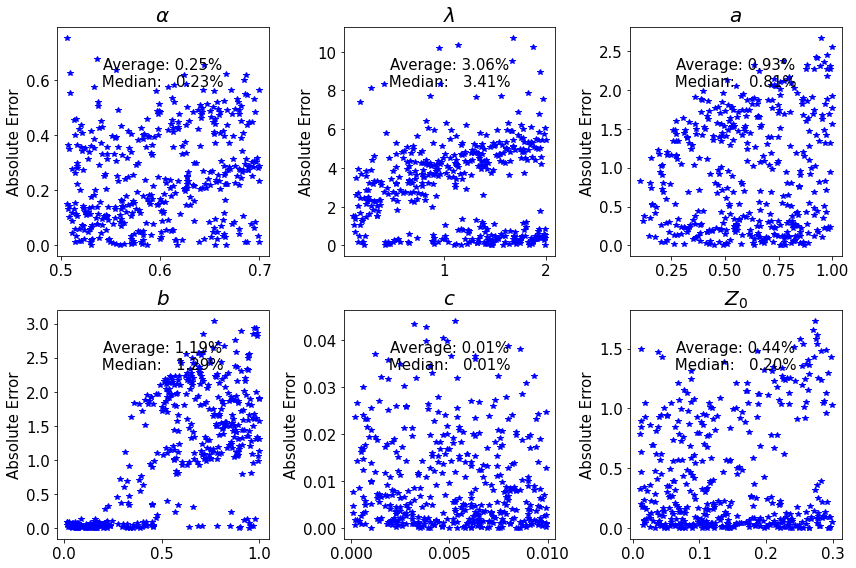

In [36]:
titles=["$\\alpha$","$\\lambda$","$a$","$b$", "$c$","$Z_0$"]
average=np.zeros([6,len(X_test)])
fig=plt.figure(figsize=(12,8))
for u in range(6):
    ax=plt.subplot(2,3,u+1)
    y=X_test[:len(X_test),u]
    plt.plot(y,np.abs(LMParameters[:len(X_test),u]-y),'b*')
    average[u,:]=np.abs(LMParameters[:len(X_test),u]-y)
    
    plt.title(titles[u],fontsize=20)
    plt.ylabel('Absolute Error',fontsize=15)
    #plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter() )
    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.tick_params(axis='both', which='minor', labelsize=15)
    plt.text(0.5, 0.8, 'Average: %1.2f%%\n Median:   %1.2f%% '%(np.mean(average[u,:]),np.quantile(average[u,:],0.5)), horizontalalignment='center',verticalalignment='center', transform=ax.transAxes,fontsize=15)
plt.tight_layout()

# plt.savefig('HestonParameterAbsoluteErrors.png', dpi=300)
plt.show()